CELL 1: IMPORTS & SETUP

In [15]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_fscore_support

# কনফিগারেশন
DATASET_ROOT = r"G:\Thesis-Fall-25-26--G-606\data"
IMAGES_DIR = os.path.join(DATASET_ROOT, "Images")
LABELS_FILE = os.path.join(DATASET_ROOT, "Labels.csv")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
EPOCHS = 15
SEED = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

Using Device: cuda


CELL 2: DATASET CLASS

In [16]:
class GlaucomaDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_name = self.annotations.iloc[index, 0]
        label_str = self.annotations.iloc[index, 2]
        img_path = os.path.join(self.root_dir, img_name)
        
        image = cv2.imread(img_path)
        if image is None:
            image = np.zeros((224, 224, 3), dtype=np.uint8)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = 1 if label_str == 'GON+' else 0
        
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(label, dtype=torch.long)

CELL 3: TRAINING FUNCTION

In [17]:
def train_and_evaluate_with_history(model, train_loader, test_loader, epochs, model_name):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    
    history = {
        'train_acc': [], 'val_acc': [],
        'train_loss': [], 'val_loss': []
    }
    
    print(f"\n--- Training {model_name} ---")
    
    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        epoch_train_acc = 100 * correct / total
        epoch_train_loss = running_loss / len(train_loader)
        history['train_acc'].append(epoch_train_acc)
        history['train_loss'].append(epoch_train_loss)
        
        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels) 
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        epoch_val_acc = 100 * val_correct / val_total
        epoch_val_loss = val_loss / len(test_loader)
        history['val_acc'].append(epoch_val_acc)
        history['val_loss'].append(epoch_val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {epoch_train_acc:.1f}% | Val Acc: {epoch_val_acc:.1f}%")
            
    return history

CELL 4: LOAD RESNET18 MODEL

In [19]:
# 1. Prepare Data
transform_aug = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = GlaucomaDataset(LABELS_FILE, IMAGES_DIR, transform=transform_aug)

# Split 80/20
indices = list(range(len(dataset)))
split = int(np.floor(0.2 * len(dataset)))
np.random.seed(SEED)
np.random.shuffle(indices)
train_sampler = SubsetRandomSampler(indices[split:])
test_sampler = SubsetRandomSampler(indices[:split])

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

# 2. Load Model
model_resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 2) # Change output layer

# 3. Train and Get History
history = train_and_evaluate_with_history(model_resnet, train_loader, test_loader, EPOCHS, "ResNet18")


--- Training ResNet18 ---
Epoch 1/15 | Train Acc: 90.5% | Val Acc: 91.9%
Epoch 2/15 | Train Acc: 96.2% | Val Acc: 94.6%
Epoch 3/15 | Train Acc: 97.8% | Val Acc: 94.0%
Epoch 4/15 | Train Acc: 98.5% | Val Acc: 98.0%
Epoch 5/15 | Train Acc: 99.3% | Val Acc: 95.3%
Epoch 6/15 | Train Acc: 98.3% | Val Acc: 96.0%
Epoch 7/15 | Train Acc: 99.7% | Val Acc: 97.3%
Epoch 8/15 | Train Acc: 99.7% | Val Acc: 96.0%
Epoch 9/15 | Train Acc: 99.8% | Val Acc: 98.0%
Epoch 10/15 | Train Acc: 99.7% | Val Acc: 97.3%
Epoch 11/15 | Train Acc: 99.2% | Val Acc: 95.3%
Epoch 12/15 | Train Acc: 99.3% | Val Acc: 94.6%
Epoch 13/15 | Train Acc: 99.5% | Val Acc: 94.6%
Epoch 14/15 | Train Acc: 98.8% | Val Acc: 93.3%
Epoch 15/15 | Train Acc: 99.5% | Val Acc: 94.6%


CELL 5: Graphs

Generating 5 Thesis Graphs...


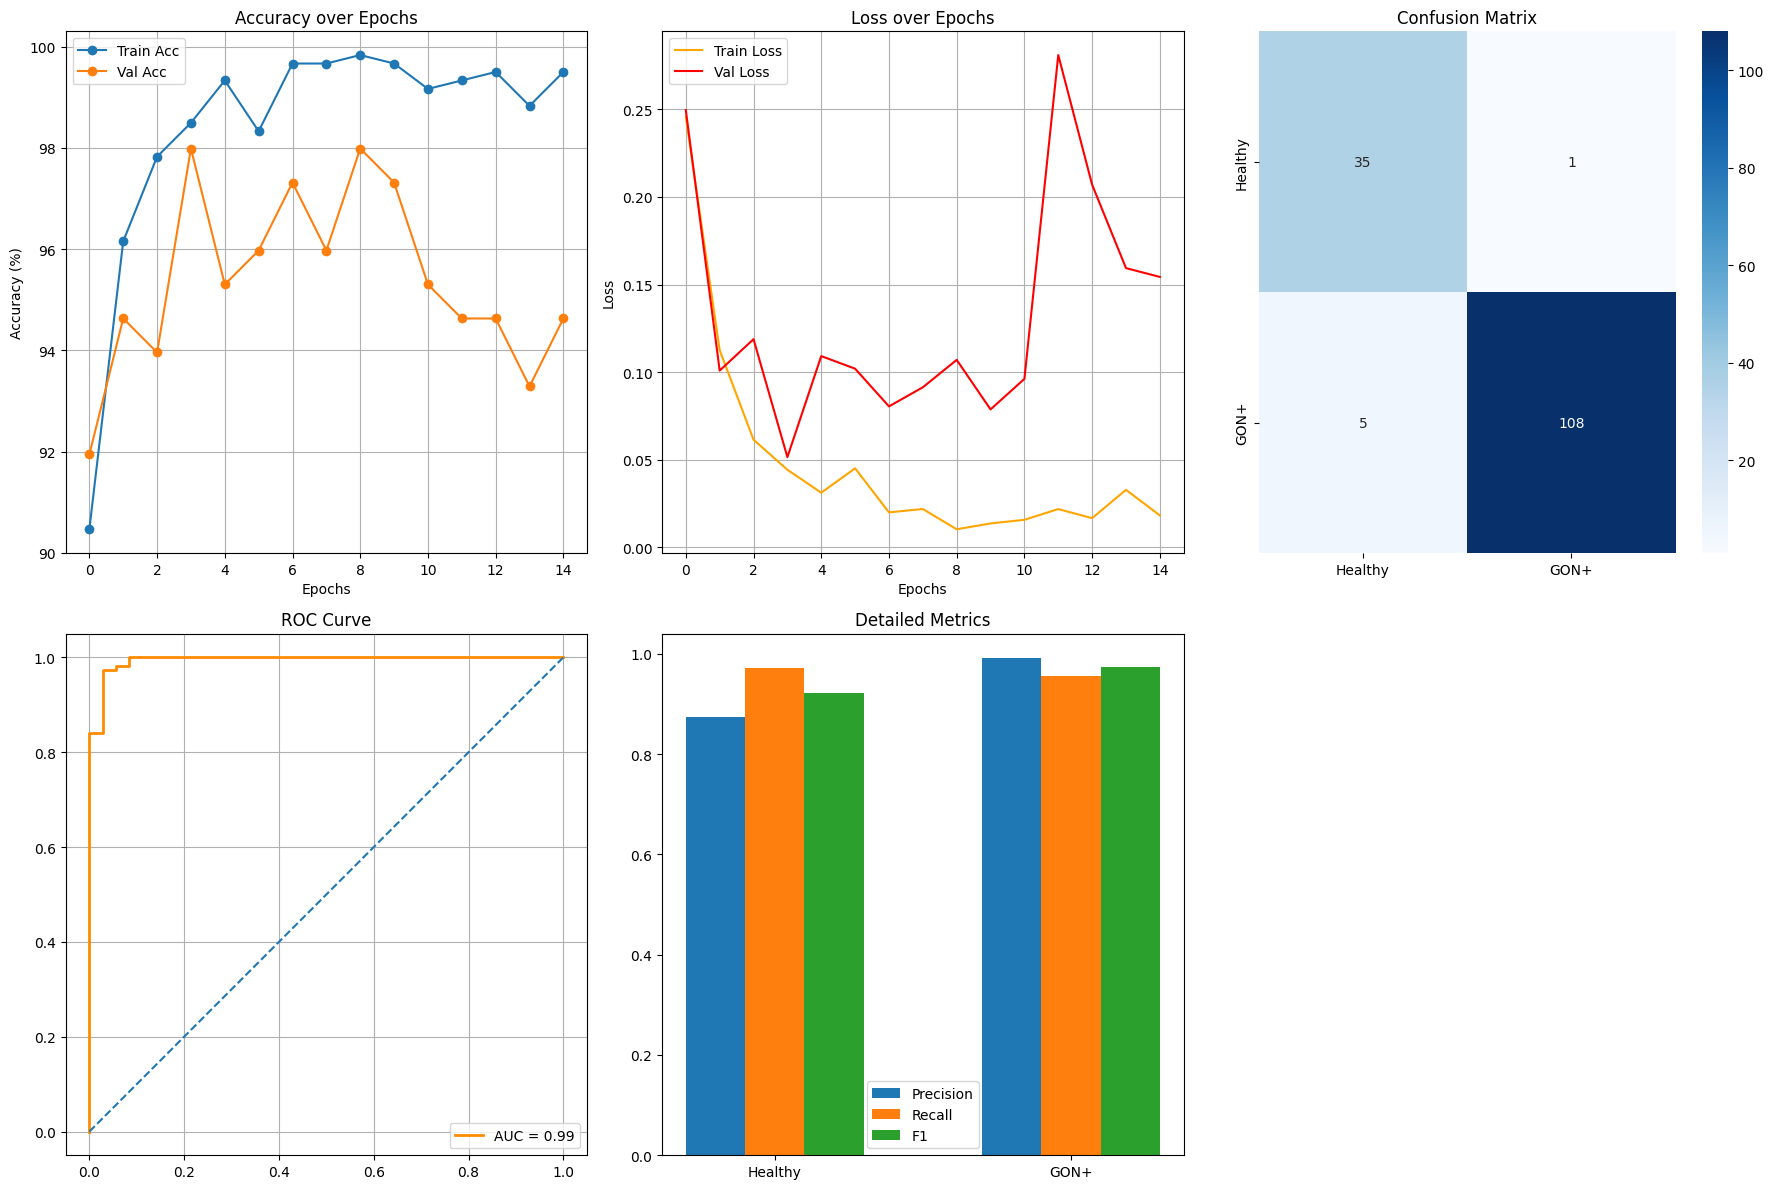

In [20]:
def show_all_graphs(history, model, loader, device):
    plt.figure(figsize=(18, 12))
    
    # 1. Accuracy Curve
    plt.subplot(2, 3, 1)
    plt.plot(history['train_acc'], label='Train Acc', marker='o')
    plt.plot(history['val_acc'], label='Val Acc', marker='o')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    # 2. Loss Curve
    plt.subplot(2, 3, 2)
    plt.plot(history['train_loss'], label='Train Loss', color='orange')
    plt.plot(history['val_loss'], label='Val Loss', color='red')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Get Predictions
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_probs.extend(probs[:, 1].cpu().numpy())

    # 3. Confusion Matrix
    plt.subplot(2, 3, 3)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'GON+'], yticklabels=['Healthy', 'GON+'])
    plt.title('Confusion Matrix')
    
    # 4. ROC-AUC Curve
    plt.subplot(2, 3, 4)
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid()

    # 5. Precision-Recall Bars
    plt.subplot(2, 3, 5)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    x = np.arange(2)
    plt.bar(x - 0.2, precision, 0.2, label='Precision')
    plt.bar(x, recall, 0.2, label='Recall')
    plt.bar(x + 0.2, f1, 0.2, label='F1')
    plt.xticks(x, ['Healthy', 'GON+'])
    plt.title('Detailed Metrics')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Show Graphs
print("Generating 5 Thesis Graphs...")
show_all_graphs(history, model_resnet, test_loader, device)

CELL 6: ResNet Prediction Visualization (Eye Images)

Showing ResNet Eye Predictions...


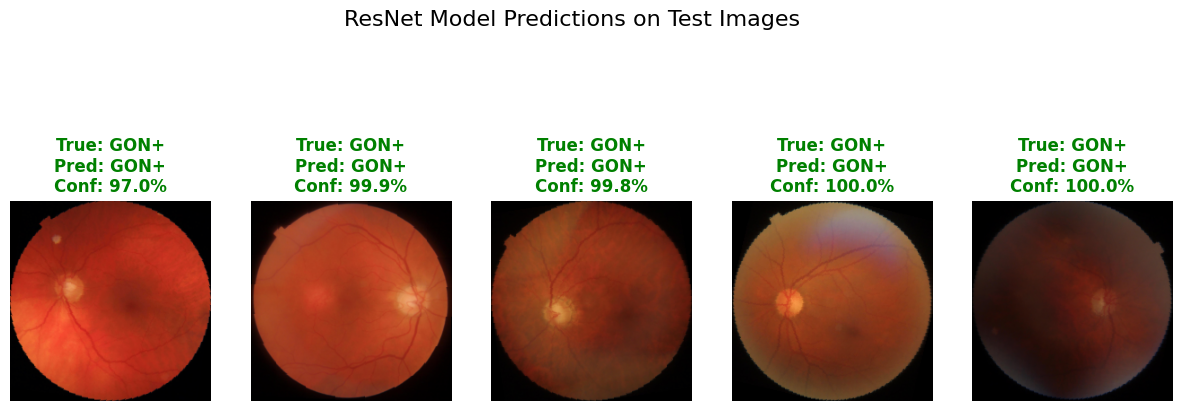

In [21]:

def visualize_resnet_predictions(model, loader, device):
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)

    # Prediction ব
    with torch.no_grad():
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        confs, preds = torch.max(probs, 1)
    
    
    plt.figure(figsize=(15, 6))
    class_names = ['Healthy', 'GON+']
    
    for i in range(min(5, len(images))): 
        ax = plt.subplot(1, 5, i+1)
        
       
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        
        true_lab = class_names[labels[i].item()]
        pred_lab = class_names[preds[i].item()]
        conf = confs[i].item() * 100
        
        
        color = 'green' if true_lab == pred_lab else 'red'
        
        plt.title(f"True: {true_lab}\nPred: {pred_lab}\nConf: {conf:.1f}%", 
                  color=color, fontweight='bold')
        plt.axis('off')
        
    plt.suptitle("ResNet Model Predictions on Test Images", fontsize=16)
    plt.show()


print("Showing ResNet Eye Predictions...")
visualize_resnet_predictions(model_resnet, test_loader, device)

CELL 7: save

In [22]:
save_path = os.path.join(DATASET_ROOT, 'resnet18_best_model.pth')
torch.save(model_resnet.state_dict(), save_path)
print(f"ResNet Model Saved at: {save_path}")

ResNet Model Saved at: G:\Thesis-Fall-25-26--G-606\data\resnet18_best_model.pth
